#### 데이터 로딩

In [11]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import torch

from model import BikeDemandMLP
from train import train_model

train_df = pd.read_csv("../data/processed/train.csv")
val_df = pd.read_csv("../data/processed/val.csv")
test_df = pd.read_csv("../data/processed/test.csv")

X_train = train_df.drop(columns=["Rented_Bike_Count"]).values
y_train = train_df["Rented_Bike_Count"].values

X_test = test_df.drop(columns=["Rented_Bike_Count"]).values
y_test = test_df["Rented_Bike_Count"].values

#### 평가 함수

In [12]:
def print_mse(name, mse):
    print(f"[ {name} ]")
    print(f"  MSE: {mse:.2f}")
    print("-" * 30)
    return {"Model": name, "MSE": mse}

results = []

#### 결정 트리 회귀

In [13]:
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse = mean_squared_error(y_test, y_pred_dt)
results.append(print_mse("Decision Tree", mse))

[ Decision Tree ]
  MSE: 56878.17
------------------------------


#### 선형 회귀

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
results.append(print_mse("Linear Regression", mse))

[ Linear Regression ]
  MSE: 179311.94
------------------------------


#### 딥러닝 MLP

Epoch 001 | Train Loss: 81244447.2500 | Val Loss: 19764079.5625
Epoch 002 | Train Loss: 75006508.9688 | Val Loss: 16314751.5938
Epoch 003 | Train Loss: 53624725.6562 | Val Loss: 10123526.8750
Epoch 004 | Train Loss: 35125587.5312 | Val Loss: 8088043.4688
Epoch 005 | Train Loss: 31717241.9375 | Val Loss: 7844151.2188
Epoch 006 | Train Loss: 30801024.8750 | Val Loss: 7619060.6719
Epoch 007 | Train Loss: 29932468.5938 | Val Loss: 7415493.6250
Epoch 008 | Train Loss: 28996718.7812 | Val Loss: 7205555.0547
Epoch 009 | Train Loss: 28144689.8594 | Val Loss: 6986865.1953
Epoch 010 | Train Loss: 27367232.2812 | Val Loss: 6763099.6797
Epoch 011 | Train Loss: 26317067.7500 | Val Loss: 6537789.6328
Epoch 012 | Train Loss: 25409450.0625 | Val Loss: 6304695.0000
Epoch 013 | Train Loss: 24408353.6094 | Val Loss: 6055635.8750
Epoch 014 | Train Loss: 23404935.8906 | Val Loss: 5822365.5625
Epoch 015 | Train Loss: 22556068.5156 | Val Loss: 5602002.3281
Epoch 016 | Train Loss: 21628703.3906 | Val Loss: 53

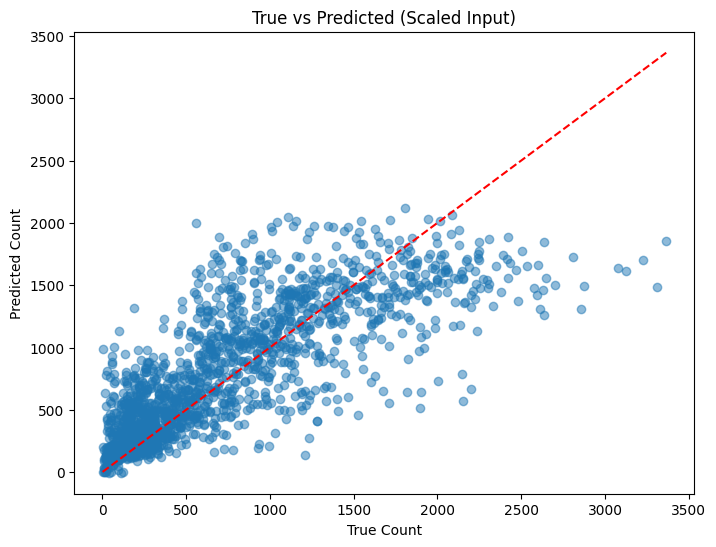

In [ ]:
import joblib
import pandas as pd
import torch
from train import train_model

# 1. 입력 특성 수 계산
X_train = pd.read_csv("../data/processed/train.csv").drop(columns=["Rented_Bike_Count"])
input_dim = X_train.shape[1]

# 2. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. 모델 학습 + 스케일러 저장됨
model = train_model(
    train_path="../data/processed/train.csv",
    val_path="../data/processed/val.csv",
    input_dim=input_dim,
    epochs=200,
    patience=10,
    device=device
)

# 4. 저장된 스케일러 로드
scaler = joblib.load("../models/input_scaler.pkl")

# 5. 테스트셋 로드 및 정규화
df_test = pd.read_csv("../data/processed/test.csv")
X_test = scaler.transform(df_test.drop(columns=["Rented_Bike_Count"]).values)
y_test = df_test["Rented_Bike_Count"].values.reshape(-1, 1)

# 6. 평가 (정규화된 X_test 사용)
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_test.astype(np.float32)).to(device)
    preds = model(X_tensor).cpu().numpy()

# 7. 평가 결과 출력 및 저장
results.append(print_mse("MLP (PyTorch)", mean_squared_error(y_test, preds)))

# 8. 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Count")
plt.ylabel("Predicted Count")
plt.title("True vs Predicted (Scaled Input)")
plt.show()

#### 결과 비교 테이블

In [16]:
df_result = pd.DataFrame(results)
display(df_result)

,Model,MSE
0,Decision Tree,56878.167442
1,Linear Regression,179311.941078
2,MLP (PyTorch),148401.593750
